### Semantic Segmentation and Regions of Interest for Obstacles Detection and Avoidance in Autonomous Surface Vessels



Realiza todos os imports necessários:

In [26]:
from tensorflow import keras
from keras_segmentation.models.segnet import vgg_segnet         
from keras_segmentation.predict import predict_video, predict_multiple, predict
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage
from skimage.draw import line
import tensorflow as tf
from matplotlib import pyplot as plt
import imageio
from PIL import Image
import random
import os
import cv2 as cv
import numpy as np
import math
import os.path
from os import path
from datetime import datetime
import time

%matplotlib inline

Configuração necessária para a utilização de GPU para o treinamento do modelo:

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Parâmetros utilizados pelo programa:

In [5]:
model_compile = {'loss': 'categorical_crossentropy',
                 'optimizer': 'adam', 
                 'metric': ['accuracy']
                }

check_points = {  'save_weights_only': True, 
                  'verbose': True,
                  'monitor': 'val_loss',
                  'mode': 'auto',
                  'save_best_only': True
                }

early_stopping = {'monitor': 'val_loss',
                  'min_delta': 0, 
                  'patience': 10,
                  'verbose': 1,
                  'restore_best_weights': True
                }

model_train = {'train_images': 'MaSTr1325_dataset_aug/images_train/',
               'train_annotations': 'MaSTr1325_dataset_aug/masks_train/', 
               'input_height': 384,
               'input_width': 512, 
               'n_classes': 4,               
               'verify_dataset': True, 
               'checkpoints_path': 'Checkpoints/',
               'epochs': 100, 
               'batch_size': 1,
               'validate': True, 
               'val_images': 'MaSTr1325_dataset_aug/images_test/',               
               'val_annotations': 'MaSTr1325_dataset_aug/masks_test/', 
               'val_batch_size': 1,
               'auto_resume_checkpoint': True, 
               'steps_per_epoch': 2100,
               'optimizer_name': 'adam',
               'load_weights': None
              }

model_evaluate = {'inp_images_dir': 'MaSTr1325_dataset/images_test/',
                  'annotations_dir': 'MaSTr1325_dataset/masks_test/', 
                  'checkpoints_path': 'Checkpoints/'
                 }

colors = {'blue': (255, 0, 0),
          'green': (0, 255, 0), 
          'red': (0, 0, 255),
          'black':(255, 255, 255),
          'purple':(191,64,191)
         }

thickness = 1 

min_detection_area = 90
CLOSEST_DETECTION_AREA = 1
MIDDLE_DETECTION_AREA = 2
DISTANT_DETECTION_AREA = 3

Definição da classe responsável pela segmentação semântica. Engloba todos os métodos relativos ao modelo de machine learning:

In [6]:
class SegmentationModel:    
    def __init__(self, n_classes, height, width):
        '''
        Constructor of Segmentation model class.
        input:
            n_classes - Number of classes on dataset
            height - Image height
            width - Image width
        '''
        
        self.n_classes = n_classes
        self.height = height
        self.width = width
        self.set_paths()
        self.set_model()
        self.set_tensorboard()
        self.compile_model()       
    
    def set_paths(self):
        '''
        Set application paths.    
        '''
        
        self.output_image_folder = "Predictions/image/"
        self.output_video_folder = "Predictions/video/"
        self.output_results_folder = "Predictions/"
        self.tensor_board_logs = "Tensorboard_Logs/"        
        
    def set_model(self):
        '''
        Set and initialize de vgg_segnet model.    
        '''
        
        self.model = vgg_segnet(n_classes=self.n_classes, input_height=self.height, input_width=self.width)
    
    def set_tensorboard(self):
        '''
        Initialize the Tensorboard module.    
        '''
        
        self.tensorboard = TensorBoard(log_dir=self.tensor_board_logs, histogram_freq=0, write_graph=True, write_images=True)
        self.tensorboard.set_model(self.model)
        
        self.callbacks = [  
            ModelCheckpoint(
                filepath = "checkpoints_callback/" + self.model.name + ".{epoch:05d}",
                save_weights_only = check_points['save_weights_only'],
                verbose = check_points['verbose'],
                monitor = check_points['monitor'], 
                mode = check_points['mode'],
                save_best_only = check_points['save_best_only'],                
            ),
            EarlyStopping(
                monitor = early_stopping['monitor'],
                min_delta = early_stopping['min_delta'],
                patience = early_stopping['patience'],
                verbose = early_stopping['verbose'],
                restore_best_weights = early_stopping['restore_best_weights']
            )  
        ]
        self.callbacks.append(self.tensorboard)
        
    def compile_model(self): 
        '''
        Compile the model.    
        '''
        
        self.model.compile(loss=model_compile['loss'],
                           optimizer=model_compile['optimizer'],
                           metrics=model_compile['metric'])
        
    def load_model_weights(self, path="Checkpoints/weights.hdf5"):
        '''
        Load model weights from previous trainings.
        input:
            path - Path to hdf5 file            
        '''
        
        self.model.load_weights(path)
        
        
    def train_model(self):
        '''
        Train the model using given parameters.        
        '''
        
        self.history = self.model.train(train_images = model_train['train_images'],    
                                         train_annotations = model_train['train_annotations'],         
                                          input_height = model_train['input_height'],                                            
                                          input_width = model_train['input_width'],
                                          n_classes = model_train['n_classes'],                                                    
                                          verify_dataset = model_train['verify_dataset'],
                                          checkpoints_path= model_train['checkpoints_path'],
                                          epochs = model_train['epochs'],
                                          batch_size = model_train['batch_size'],
                                          validate = model_train['validate'],                                                  
                                          val_images = model_train['val_images'],                    
                                          val_annotations = model_train['val_annotations'],                
                                          val_batch_size = model_train['val_batch_size'],                                              
                                          auto_resume_checkpoint = model_train['auto_resume_checkpoint'],
                                          steps_per_epoch = model_train['steps_per_epoch'],
                                          load_weights = model_train['load_weights'],      
                                          optimizer_name = model_train['optimizer_name'],                                       
                                          callbacks = self.callbacks)
    
    def save_model_weights(self, path="Checkpoints/weights.hdf5"):
        '''
        Save model weights.
        input:
            path - Path to hdf5 file            
        '''
        
        self.model.save_weights(path)
    
    def plot_training_accuracy(self):
        '''
        Plot the training accuracy.        
        '''
        
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('VGG + Segnet - Acurácia')
        plt.ylabel('Acurácia')
        plt.xlabel('Época #')
        plt.legend(['Treinamento', 'Validação'], loc='lower right')
        plt.grid(True)
        fig_accuracy = plt.gcf()
        fig_accuracy.savefig(self.output_results_folder + 'accuracy.png', dpi=200)
    
    def plot_training_loss(self):
        '''
        Plot the training loss.        
        '''
        
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('VGG + Segnet - Erro')
        plt.ylabel('Erro')
        plt.xlabel('Época #')
        plt.legend(['Treinamento', 'Validação'], loc='upper right')
        plt.grid(True)
        fig_loss = plt.gcf()
        fig_loss.savefig(self.output_results_folder + 'loss.png', dpi=200)
        
    def evaluate_model(self):
        '''
        Evaluate the model.        
        '''
        print(self.model.evaluate_segmentation(inp_images_dir = model_evaluate['inp_images_dir'],
                                               annotations_dir = model_evaluate['annotations_dir'],
                                               checkpoints_path = model_evaluate['checkpoints_path']))
        

Definição da classe Obstacle, responsável por armazenar os dados dos obstaculos encontrados:

In [7]:
class Obstacle():
    def __init__(self, contour, area, height, width):
        '''
        Constructor of Obstacle class.                
        input:
            - contour: Object contour 
            - area: Area where object was detected
            - height: Image height
            - width: Image width                   
        '''      
        
        self.contour = contour
        self.detection_area = area
        self.image_height = height
        self.image_width = width
        self.boat_position = [self.image_width//2, self.image_height]
        self.new_angle = 0.0
        
        self.calculate_magnitude()
        self.calculate_center()
        self.calculate_angle_from_center()
        self.calculate_closest_point()
        self.calculate_angle_from_closest()
        self.define_object_quadrant()
      
        
    def calculate_magnitude(self):
        '''
        Calculate data related to obstacle magnitude.                        
        '''      
        self.area = cv.contourArea(self.contour)
        self.perimeter = round(cv.arcLength(self.contour, True))        
        self.bound_rect = cv.boundingRect(self.contour)
        
    def calculate_center(self):
        '''
        Calculate obstacle center.        
        '''      
        M = cv.moments(self.contour)
        if M['m00'] != 0:
            self.center_x = int(M['m10']/M['m00'])
            self.center_y = int(M['m01']/M['m00'])
        else:
            print('Could not calculate object ceter')
        self.distance_center = ((self.center_x - self.boat_position[0]) ** 2 + (self.center_y - self.boat_position[0]) ** 2) ** 0.5 
    
    def calculate_angle_from_center(self):  
        '''
        Calculate angle from obstacle center.                        
        '''              
        self.angle_from_center = math.atan2(-self.boat_position[1] + self.center_y, -self.boat_position[0] + self.center_x)        
        
    def calculate_closest_point(self):
        '''
        Calculate the closest point of boat         
        '''      
        distance = []
        
        for points in self.contour:            
            aux = ((points[0][0] - self.boat_position[0]) ** 2 + (points[0][1] - self.boat_position[0]) ** 2) ** 0.5 
            distance.append(aux)  
            
        closest_idx = np.argmin(distance)
        self.closest_point = self.contour[closest_idx]        
        self.distance = distance[closest_idx]
        
    def calculate_angle_from_closest(self):
        '''
        Calculate angle from closest point to boat                      
        '''      
        self.angle_from_closest = math.atan2(-self.boat_position[1] + self.closest_point[0][0],
                                            -self.boat_position[0] + self.closest_point[0][1])
    
    def define_object_quadrant(self):
        '''
        Define where is the obstacle side.           
        '''      
        if self.closest_point[0][0] < self.image_width//2:
            self.object_quadrant = 'LEFT'
        else:
            self.object_quadrant = 'RIGHT'
    
            
    def draw_stuff(self):
        '''
        Draw functions related to this object
        '''      
        pass

    def obstacle_data(self):
        '''
        Return obstacle basic data
        '''
        
        data = 'Detection: {}, Area: {}, Ang_C: {}, Closest: {}, Distance: {}, Ang_Clos: {}'.format(
                            self.detection_area,
                            self.area,
                            self.angle_from_center,
                            self.closest_point,
                            self.distance,
                            self.angle_from_closest)
        return data

Definição da classe ObstacleData, responsável por escrever os dados a serem enviados para a embarcacao:

In [8]:
class ObstacleData():
    def __init__(self, file_path):
        '''
        Constructor of ObstacleData class
        input:
            file_path: The file path to save data
        '''
        
        if path.exists(file_path):
            self.path = file_path
        else:
            self.path = file_path
            with open(file_path, 'w') as f:
                header = self.create_header()                
                f.write(header)
                f.write('\n')

    def create_header(self):
        '''
        If file doesn't exist, create header
        output:
            header_as_string: All header data as string format
        '''
        
        self.header = ['Date',
                      'Time',
                      'Detection Area', 
                      'Quadrant', 
                      'Center X',
                      'Center Y',
                      'Object Area',
                      'Closest Point X',
                      'Closest Point Y',
                      'Distance',
                      'Angle from Center',
                      'Angle from Closest',
                      'New Angle'] 
        
        header_as_string = ''
        for item in self.header:
            header_as_string = header_as_string + item + ','
                
        return header_as_string
    
    def write_data(self, obstacles):
        '''
        Write all obstacles data
        input:
            obstacles: List of all obstacles found
        '''
        
        now = datetime.now()        
        for obstacle in obstacles:
            string_to_write = ''
            string_to_write = string_to_write + now.strftime("%d/%m/%Y") + ','
            string_to_write = string_to_write + now.strftime("%H:%M:%S") + ','
            string_to_write = string_to_write + str(obstacle.detection_area) + ','
            string_to_write = string_to_write + obstacle.object_quadrant + ','
            string_to_write = string_to_write + str(obstacle.center_x) + ','
            string_to_write = string_to_write + str(obstacle.center_y) + ','            
            string_to_write = string_to_write + str(obstacle.area) + ','            
            string_to_write = string_to_write + str(obstacle.closest_point[0][0]) + ','
            string_to_write = string_to_write + str(obstacle.closest_point[0][1]) + ','
            string_to_write = string_to_write + str(obstacle.distance) + ','            
            string_to_write = string_to_write + str(round(obstacle.angle_from_center * 180/math.pi, 4)) + ','
            string_to_write = string_to_write + str(round(obstacle.angle_from_closest * 180/math.pi,4)) + ','
            string_to_write = string_to_write + str(round(obstacle.new_angle * 180.0 /math.pi, 2)) + ','
            string_to_write = string_to_write + '\n'
            
            with open(self.path, 'a') as f:  
                f.write(string_to_write)

Definição da classe PostProcessing, responsável por todo o pós processamento das imagens:

In [9]:
class PostProcessing():
    def __init__(self):
        pass
        
    def set_image(self, image, height, width):
        '''
        Set the image to be processed.        
        input:
            - image: Image to process
            - height: Image height
            - width: Image width
        '''
        
        self.image = image
        self.height = height
        self.width = width
        self.half_height = height//2
        self.half_width = width//2  
        self.boat_position = [self.half_width, self.height]
    
    def convert_to_gray(self):
        '''
        Convert the image to gray scale.                
        output:
            - image in gray scale
        '''
        
        return cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
    
    def canny_filter(self, gray): 
        '''
        Apply the Canny Filter on image to extract the edges.                
        input:
            - gray: Image in gray scale
        output:
            dst: Image with edges
            cdst: Original Image
            cdstP: Images overlayed
        '''
        
        v = np.median(gray) 
        sigma = 0.33
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        dst = cv.Canny(gray, lower, upper)
        
        cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
        cdstP = np.copy(cdst)
        
        return dst, cdst, cdstP
    
    def houg_lines(self, dst): 
        '''
        Apply the Hough Transform to extract line segments.                
        input:
            - dst: Image with edges from Canny
        output:
            center: Center of heghest line segment found
            angle_degree: Line angle
            x1_: X position of first point
            y1_: Y position of first point
            x2_: X position of second point
            y2_: Y position of second point           
        '''
        
        lines = cv.HoughLines(dst, 1, np.pi/180, self.width//5, 100, 0) 
            
        if lines is not None:       
            distances = []
            for i in range(0, len(lines)):                        
                rho = lines[i][0][0]
                theta = lines[i][0][1]
                a = math.cos(theta)
                b = math.sin(theta)
                x0 = a * rho
                y0 = b * rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))                        
                distances.append(math.sqrt((x2 - x1)**2 + (y2 - y1)**2 ))
        
            max_distance_idx = distances.index(max(distances))
            rho = lines[max_distance_idx][0][0]
            theta = lines[max_distance_idx][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1_ = int(x0 + 1000*(-b))
            y1_ = int(y0 + 1000*(a))
            x2_ = int(x0 - 1000*(-b))
            y2_ = int(y0 - 1000*(a))          
            cv.line(self.image, (x1_,y1_), (x2_,y2_), colors['blue'], 3, cv.LINE_AA)  
            self.hl_start = [x1_, y1_]
            self.hl_end = [x2_, y2_]
        
            angle_rad = math.atan2(y1_ - y2_, x1_ - x2_)
            angle_degree = round(angle_rad * 180/math.pi,2)  
            cv.putText(self.image, f'Inclination:{angle_degree}',
                      (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, 
                       colors['red'], 2)                
        
            t = 0.1 if (x2_ - x1_ == 0.0) else (x2_ - x1_)            
            
            a = (y2_ - y1_)/t        
            b = y1_ - a * x1_
            self.center_hl = int((self.half_width) * a + b)          
        
            if self.center_hl > self.width or self.center_hl < 0:
                self.center_hl = self.half_width
        
            return angle_degree, x1_, y1_, x2_, y2_
    
        cv.putText(image, f'No HL found!', (self.half_width, self.half_height),
                   cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        print('No HL')
        
        return 180.0, 0, self.half_height, self.width, self.half_height  

    
    def define_detection_area(self, y1, y2):  
        '''
        Define all detection areas on image.                
        input:
            - center: Image with edges from Canny
            - y1: Y position of first line point
            - y2: Y position of second line point 
        output:
            left_area: Left interest area
            right_area: Right interest area
            closest_area: The closest interest area
            middle_area: The middle interest area
            distant_area: The distant area
        '''        
                
        left_pos = (self.height - y1)//2 
        left_p1 = (0, self.height - left_pos)    
        left_p2 = (self.half_width, self.center_hl)            
        self.start_left_area = left_pos
    
        # Define the left detection area
        pts = np.array([[0, self.height],
                        [0, self.height - left_pos],
                        [self.half_width, self.center_hl],
                        [self.half_width, self.width]], np.int32)
        left_area = pts.reshape((-1,1,2)) 
    
    
        right_pos = (self.height - y2)//2 
        left_p1 = (self.width, self.height - right_pos)
        left_p2 = (self.half_width, self.center_hl)  
        self.start_right_area = right_pos
    
        # Define the right detection area
        pts = np.array([[self.width, self.height],
                        [self.width, self.height - right_pos],
                        [self.half_width, self.center_hl],
                        [self.half_width, self.height]], np.int32)
        right_area = pts.reshape((-1,1,2))         
    
        # Get specific points inside line
        p1_l = (0, self.height - left_pos)
        p2_l = (self.half_width, self.center_hl)    
        p1_r = (self.width, self.height - right_pos)
        p2_r = (self.half_width, self.center_hl)    
        discrete_line_left = list(zip(*line(*p1_l, *p2_l)))
        discrete_line_right = list(zip(*line(*p1_r, *p2_r)))
    
        # Closest boat area
        p1 = discrete_line_left[len(discrete_line_left)//10]
        p2 = discrete_line_right[len(discrete_line_right)//10]         
    
        # Distant area
        p1_ = discrete_line_left[len(discrete_line_left)//2 + len(discrete_line_left)//5]
        p2_ = discrete_line_right[len(discrete_line_right)//2 + len(discrete_line_left)//5]         
    
        #Mapping areas
        pts = np.array([[0, self.height],
                        [0, self.height - left_pos],
                        [p1[0], p1[1]],
                        [p2[0], p2[1]],
                        [self.width, self.height - right_pos],
                        [self.width, self.height],
                        [0, self.height]], np.int32)
        self.closest_area = pts.reshape((-1,1,2))
        self.closest_area_distance_l = math.sqrt((p1[0] - self.boat_position[0])**2 + (p1[1] - self.boat_position[1])**2 )
        self.closest_area_distance_r = math.sqrt((p2[0] - self.boat_position[0])**2 + (p2[1] - self.boat_position[1])**2 )
    
        pts = np.array([[p1[0], p1[1]],
                        [p1_[0], p1_[1]],
                        [p2_[0], p2_[1]],
                        [p2[0], p2[1]],
                        [p1[0], p1[1]]], np.int32)
        self.middle_area = pts.reshape((-1,1,2))         
        self.middle_area_distance_l = math.sqrt((p1_[0] - self.boat_position[0])**2 + (p1_[1] - self.boat_position[1])**2 )
        self.middle_area_distance_r = math.sqrt((p2_[0] - self.boat_position[0])**2 + (p2_[1] - self.boat_position[1])**2 )
        
    
        pts = np.array([[p1_[0], p1_[1]],
                        [self.half_width, self.center_hl],
                        [p2_[0], p2_[1]],
                        [p1_[0], p1_[1]]], np.int32)
        self.distant_area = pts.reshape((-1,1,2))
        self.distant_area_distance_l = math.sqrt((p1_[0] - self.boat_position[0])**2 + (p1_[1] - self.boat_position[1])**2 )
        self.distant_area_distance_r = math.sqrt((p2_[0] - self.boat_position[0])**2 + (p2_[1] - self.boat_position[1])**2 )
    
        return left_area, right_area
    
    def detect_obstacles(self, x1, y1, x2, y2):
        '''
        Detect all obstacles on image.                
        input:
            - x1: X position of first (left) point of HL
            - y1: Y position of first (left) point of HL
            - x2: X position of second (right) point of HL
            - y2: Y position of second (right) point of HL
            - closest_area: Points to define the closest interest area
            - middle_area: Points to define the middle interest area
            - distant_area: Points to define the distant interest area
        output:
            obstacles: List of all detected obstacles in Obstacle format              
        '''        
        
        original = self.image.copy()         
        boat_position = [self.half_width, self.height]
        
        #Apply a mask on bottom image
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY) 
        
        pts = np.array([[0,self.height],[x1,y1],[x2,y2],[self.width,self.height]], np.int32)    
        mask = np.zeros(gray.shape, dtype = np.uint8)                
        mask = cv.fillPoly(mask, pts=[pts], color=colors['black']) 
        
        masked = cv.bitwise_and(gray, gray, mask = mask)                
    
        thresh = cv.threshold(masked, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]         
        
        cnts = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) 
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]        
        
        obstacles = []
    
        for c in cnts:                
            x,y,w,h = cv.boundingRect(c)  
            
            if (y >= y1 and y >= y2):  
                
                area = cv.contourArea(c)                
                if area > min_detection_area:   
                    
                    result_closest = []
                    result_middle = []
                    result_distant = []                    
                    
                    for point in c:
                        result_closest.append(cv.pointPolygonTest(self.closest_area, (int(point[0][0]), int(point[0][1])), False))
                        result_middle.append(cv.pointPolygonTest(self.middle_area, (int(point[0][0]), int(point[0][1])), False))
                        result_distant.append(cv.pointPolygonTest(self.distant_area, (int(point[0][0]), int(point[0][1])), False))                        
                        
                    if (result_middle.count(1) != 0) or (result_middle.count(0) != 0):                                            
                        cv.rectangle(self.image, (x, y), (x + w, y + h), colors['purple'], 1)
                        obstacle = Obstacle(c, MIDDLE_DETECTION_AREA, self.height, self.width )
                        obstacles.append(obstacle)
                    elif (result_closest.count(1) != 0) or (result_closest.count(0) != 0):                                            
                        cv.rectangle(self.image, (x, y), (x + w, y + h), colors['red'], 1)
                        obstacle = Obstacle(c, CLOSEST_DETECTION_AREA, self.height, self.width )
                        obstacles.append(obstacle)
                    else: 
                        cv.rectangle(self.image, (x, y), (x + w, y + h), colors['green'], 1)
                        obstacle = Obstacle(c, DISTANT_DETECTION_AREA, self.height, self.width )
                        obstacles.append(obstacle)
                        
                else:
                    cv.rectangle(self.image, (x, y), (x + w, y + h), colors['blue'], 1)
                    
        return obstacles
    
    def draw_direction_arrow(self):
        '''
        Draw the direct arrow and ellipse on image.                
        input:
            - center: Center of HL                    
        '''      
        
        radius = self.width//6
        center_ = (self.half_width, self.height)
        axes = (radius, radius)
        angle = 0
        startAngle = 180
        endAngle = 360    
        cv.ellipse(self.image, center_, axes, angle, startAngle, endAngle, colors['blue'], thickness, 8, 0)
    
        start_point = (self.half_width, self.height)
        end_point = (self.half_width, (self.height - radius)-10)  
        cv.arrowedLine(self.image, start_point, end_point, colors['blue'], thickness, tipLength = 0.07)
    
    
    def draw_detection_area(self, y1, y2):  
        '''
        Draw the detection area on image.                
        input:   
            - center: Center position of HL
            - y1: Y1 position of HL            
            - y2: Y2 position of HL                           
        '''      
    
        #Draw the object detection area - Left
        left_pos = (self.height - y1)//2 
        left_p1 = (0, self.height - left_pos)    
        left_p2 = (self.half_width, self.center_hl)    
        cv.line(self.image, left_p1, left_p2, colors['blue'], thickness, cv.LINE_AA)     
    
        #Draw the object detection area - Left
        right_pos = (self.height - y2)//2 
        left_p1 = (self.width, self.height - right_pos)
        left_p2 = (self.half_width, self.center_hl)
        cv.line(image, left_p1, left_p2, colors['blue'], thickness, cv.LINE_AA)
    
        # DRAW HORIZONTAL LINES ON SEARCH AREA
        p1_l = (0, self.height - left_pos)
        p2_l = (self.half_width, self.center_hl)    
        p1_r = (self.width, self.height - right_pos)
        p2_r = (self.half_width, self.center_hl)    
        discrete_line_left = list(zip(*line(*p1_l, *p2_l)))
        discrete_line_right = list(zip(*line(*p1_r, *p2_r)))
    
        # Closest boat area
        p1 = discrete_line_left[len(discrete_line_left)//10]
        p2 = discrete_line_right[len(discrete_line_right)//10] 
        cv.line(image, p1, p2, colors['blue'], thickness, cv.LINE_AA)          
    
        # Far area
        p1_ = discrete_line_left[len(discrete_line_left)//2 + len(discrete_line_left)//5]
        p2_ = discrete_line_right[len(discrete_line_right)//2 + len(discrete_line_left)//5] 
        cv.line(image, p1_, p2_, colors['blue'], thickness, cv.LINE_AA)     

        
        
    def angle_correction(self, angle, quadrant, area, distance):
        '''
        Calculate the angle factor to use.                        
        '''
        
        if area == CLOSEST_DETECTION_AREA:            
            if quadrant == 'LEFT':                 
                return ( math.pi - angle + math.pi/(distance*distance))
            else:                                    
                return (-math.pi/2 + angle + math.pi/(distance*distance))        
        
        if area == MIDDLE_DETECTION_AREA:
            if quadrant == 'LEFT':                   
                return (math.pi - angle + math.pi/distance)
            else:                 
                return (-math.pi/2 + angle + math.pi/distance)
    
    def calculate_new_angle(self, obstacles): 
        '''
        Detect all obstacles on image.                
        input:
            - obstacles: List of detected obstacles.                            
        '''              
        
        #self.boat_position = (self.half_width, 200)
        
        line_lenght = 115
        for obstacle in obstacles:
            if obstacle.detection_area == CLOSEST_DETECTION_AREA:                
                print(obstacle.distance)
                if obstacle.object_quadrant == 'LEFT': 
                    obstacle.new_angle = math.pi - obstacle.angle_from_center - (obstacle.distance_center/self.height)                    
                    
                    p2_x = int(self.boat_position[0] + line_lenght * math.cos(obstacle.new_angle))
                    p2_y = int(self.boat_position[1] + line_lenght * math.sin(obstacle.new_angle))                     
                    cv.arrowedLine(self.image, self.boat_position, (p2_x,p2_y), colors['red'], 2, tipLength = 0.07)                                        
                    cv.putText(image, f'Angle:{round(obstacle.new_angle * 180.0 /math.pi,2)}',
                              (self.width - 100, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, colors['red'], 2)                     
                else:                                                              
                    obstacle.new_angle = -math.pi/2 + obstacle.angle_from_center + (obstacle.distance_center/self.height)
                    
                    
                    p2_x = int(self.boat_position[0] + line_lenght * math.cos(obstacle.new_angle))
                    p2_y = int(self.boat_position[1] + line_lenght * math.sin(obstacle.new_angle))
                    cv.arrowedLine(self.image, self.boat_position, (p2_x,p2_y), colors['red'], 2, tipLength = 0.07)                    
                    cv.putText(image, f'Angle:{round(obstacle.new_angle * 180.0 /math.pi, 2)}',
                              (self.width - 100, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, colors['red'], 2)                       
                
            if obstacle.detection_area == MIDDLE_DETECTION_AREA:
                
                if obstacle.object_quadrant == 'LEFT':                     
                    obstacle.new_angle = math.pi - obstacle.angle_from_center + (math.pi * self.height)/obstacle.distance_center                   
                   
                    p2_x = int(self.boat_position[0] + line_lenght * math.cos(obstacle.new_angle))
                    p2_y = int(self.boat_position[1] + line_lenght * math.sin(obstacle.new_angle)) 
                    cv.arrowedLine(self.image, self.boat_position, (p2_x,p2_y), colors['purple'], 2, tipLength = 0.07)                                        
                    cv.putText(image, f'Angle:{round(obstacle.new_angle * 180.0 /math.pi,2)}',
                              (self.width - 100, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, colors['red'], 2)      
                    
                    
                else:
                    obstacle.new_angle = -math.pi/2 + obstacle.angle_from_center + (math.pi * self.height)/obstacle.distance_center       
                    
                    p2_x = int(self.boat_position[0] + line_lenght * math.cos(obstacle.new_angle))
                    p2_y = int(self.boat_position[1] + line_lenght * math.sin(obstacle.new_angle))
                    cv.arrowedLine(self.image, self.boat_position, (p2_x,p2_y), colors['red'], 2, tipLength = 0.07)                                        
                    cv.putText(image, f'Angle:{round(obstacle.new_angle * 180.0 /math.pi, 2)}',
                              (self.width - 100, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, colors['purple'], 2)                        
                    
                    
            if obstacle.detection_area == DISTANT_DETECTION_AREA:                
                cv.line(self.image, self.boat_position, (obstacle.center_x, obstacle.center_y), colors['green'], thickness, cv.LINE_AA)
                
                
                
  

In [10]:
def transfer(px, py, theta):
    transfer = np.zeros((2, 2))
    transfer[0, 0] = np.cos(theta)
    transfer[0, 1] = -np.sin(theta)
    transfer[1, 0] = np.sin(theta)
    transfer[1, 1] = np.cos(theta)
    vec = np.array([px, py])
    return np.matmul(transfer, vec)

def coef_reta(pi, pf):
    a = (pf[1] - pi[1])/(pf[0] - pi[0])
    b = pf[1] - a * pf[0]
    return a, b

def get_dividers(a, n):
    div = a.shape[0]//n
    divs = []
    inds = []    
    for i, elem in enumerate(a):
        if np.mod(i, div) == 0 and i > 0:
            divs.append(elem)
            inds.append(i)    
    return divs, inds

def compute_angle(obs, centerx, ymin):
    return np.arctan((obs[1] - ymin)/(obs[0] - centerx))

def limit_angle(angle):
    if angle > np.pi:
        angle = np.pi
    if angle < 0:
        angle = 0        
    return angle

Exibe uma imagem aleatório do dataset de treino com sua respectiva máscara

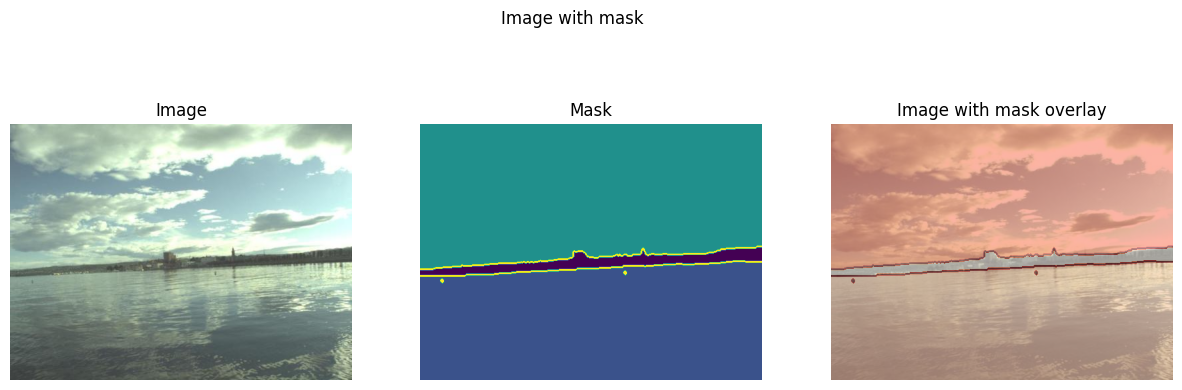

In [13]:
random_file = random.choice(os.listdir("MaSTr1325_dataset/MaSTr1325_dataset/images_train/"))
mask_name = random_file.split('.')

image_test = Image.open("MaSTr1325_dataset/MaSTr1325_dataset/images_train/" + random_file)
image_mask = Image.open("MaSTr1325_dataset/MaSTr1325_dataset/masks_train/" + mask_name[0] + '.png')

def plot_image_and_mask(image, mask):
    '''
    Function to plot a single prediction:
    input:
        image - PIL image 
        mask - PIL image with corresponding mask
    '''
    fig, axs = plt.subplots(1, 3, figsize=(15,5))

    #plot the original data
    axs[0].imshow(image) 
    axs[0].axis('off')
    axs[0].set_title('Image')

    #plot the mask
    axs[1].imshow(mask)
    axs[1].axis('off')   
    axs[1].set_title('Mask')
    
    #plot image and add the mask
    axs[2].imshow(image)
    axs[2].imshow(mask, alpha = 0.5, cmap = "Reds")
    axs[2].axis('off')   
    axs[2].set_title('Image with mask overlay')

    # set suptitle
    plt.suptitle('Image with mask')
    plt.show()

# plot image and a mask
plot_image_and_mask(image_test, image_mask)

Cria e o modelo de Machine Learning e executa todas as operações necessárias:

In [14]:
seg_model = SegmentationModel(5, 384, 512)

# Load a pre-trained model
seg_model.load_model_weights(path="Checkpoints/weights00.hdf5")

# Training a new model
# seg_model.train_model()
# seg_model.plot_training_accuracy()
# seg_model.plot_training_loss()

2024-10-17 14:48:54.816611: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-17 14:48:54.816809: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/henrique/miniconda3/envs/boat_ic/lib/python3.7/site-packages/cv2/../../lib64:/home/henrique/ros2_ws/install/turtlesim/lib:/home/henrique/ros2_ws/install/examples_rclcpp_wait_set/lib:/home/henrique/ros2_ws/install/examples_rclcpp_minimal_subscriber/lib:/home/henrique/ros2_ws/install/examples_rclcpp_minimal_composition/lib:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-10-17 14:48:54.816819: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-17 14:48:54.816831: I tensorflow/stream_executor/cuda/cuda_diagnos

Faz todas as predições e executa o pós processamento dos frames:

In [31]:
start = time.time()
modd_data = "MODD/MODD2_video_data/video_data/kope67-00-00004500-00005050/frames/"

file_list = os.listdir(modd_data)
processing = PostProcessing()
data_writer = ObstacleData('data/data.dat')

for idx, img in enumerate(file_list):
    
    # Load the image/frame
    output_image = seg_model.output_image_folder + "05/MODD_" + str(idx) + ".jpg"    
    # out = seg_model.model.predict_segmentation(inp=modd_data + img, out_fname = output_image )    
    out = predict(model=seg_model.model, inp=modd_data + img, out_fname = output_image)
    print(out)
    
    image = cv.imread(output_image, cv.IMREAD_COLOR) 
    
    # Set the data to PostProcessing object
    # processing.set_image(image, image.shape[0], image.shape[1])
    
    # # Convert to Gray and apply Canny Filter
    # gray = processing.convert_to_gray()
    # dst, cdst, cdstP = processing.canny_filter(gray)    
    
    # # Apply Hough Lines Transform
    # boat_angle, x1_, y1_, x2_, y2_ = processing.houg_lines(dst)
    
    # # Define the detection areas
    # left_area, right_area = processing.define_detection_area(y1_, y2_)
    
    # # Detecting obstacles
    # obstacles = processing.detect_obstacles(x1_, y1_, x2_, y2_)  
    
    # # Calculate new angles for boat
    # if obstacles:        
    #     processing.calculate_new_angle(obstacles)
    #     data_writer.write_data(obstacles)
    
    # # Draw the direction arrow and ellipse
    # processing.draw_direction_arrow()
    
    # # Draw the detection area
    # processing.draw_detection_area(y1_, y2_)  
    
    # # Overlay original image
    # inp_path = modd_data + img
    # background = cv.imread(inp_path, cv.IMREAD_COLOR)
    
    # #image = cv.addWeighted(processing.image, 0.5, background, 0.5, -1) 
    # #img = cv.imwrite(output_image, image)
    
    # cv.imwrite(output_image, cv.addWeighted(processing.image, 0.5, background, 0.5, -1))
    
end = time.time()
 
print("Time elapsed: ", end - start)

[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


[ WARN:0@1314.393] global loadsave.cpp:241 findDecoder imread_('Predictions/image/05/MODD_0.jpg'): can't open/read file: check file path/integrity


[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


[ WARN:0@1314.890] global loadsave.cpp:241 findDecoder imread_('Predictions/image/05/MODD_1.jpg'): can't open/read file: check file path/integrity


[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


[ WARN:0@1315.368] global loadsave.cpp:241 findDecoder imread_('Predictions/image/05/MODD_2.jpg'): can't open/read file: check file path/integrity


[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


[ WARN:0@1315.863] global loadsave.cpp:241 findDecoder imread_('Predictions/image/05/MODD_3.jpg'): can't open/read file: check file path/integrity


[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


[ WARN:0@1316.358] global loadsave.cpp:241 findDecoder imread_('Predictions/image/05/MODD_4.jpg'): can't open/read file: check file path/integrity


[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


[ WARN:0@1316.830] global loadsave.cpp:241 findDecoder imread_('Predictions/image/05/MODD_5.jpg'): can't open/read file: check file path/integrity


[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


[ WARN:0@1317.282] global loadsave.cpp:241 findDecoder imread_('Predictions/image/05/MODD_6.jpg'): can't open/read file: check file path/integrity


KeyboardInterrupt: 